In [ ]:
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.quantum_info import StabilizerState, Statevector, PauliList

H_X = np.array([
[1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0],
[1,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0],
[1,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0],
[0,1,1,0,1,0,0,1,0,0,0,0,0,0,0,0],
[1,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0],
[1,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0],
[0,1,1,0,0,0,0,0,1,0,0,1,0,0,0,0],
[1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0],
[0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0],
[0,0,1,0,1,0,0,0,1,0,0,0,0,0,1,0],
[1,1,1,0,1,0,0,0,1,0,0,0,0,0,0,1],
], dtype=int)

H_Z = np.array([
[1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0],
[1,1,1,1,0,0,0,0,1,1,1,1,0,0,0,0],
[1,1,0,0,1,1,0,0,1,1,0,0,1,1,0,0],
[1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0],
], dtype=int)

n = H_X.shape[1]   

comm = (H_X @ H_Z.T) % 2
if np.any(comm != 0):
    print("Warning: some X-checks anti-commute with some Z-checks! The CSS condition fails.")
    print("Nonzero entries in H_X * H_Z^T (mod 2):")
    print(np.where(comm != 0))
else:
    print("CSS commutation OK: all X rows commute with all Z rows.")

stabilizers = []
for row in H_X:
    s = ''.join('X' if bit==1 else 'I' for bit in row)
    stabilizers.append(s)

for row in H_Z:
    s = ''.join('Z' if bit==1 else 'I' for bit in row)
    stabilizers.append(s)

print(f"Total stabilizers (X then Z): {len(stabilizers)}")
for i,s in enumerate(stabilizers[:]):
    print(i, s)

CSS commutation OK: all X rows commute with all Z rows.
Total stabilizers (X then Z): 15
0 XXXXIIIIIIIIIIII
1 XXIIXXIIIIIIIIII
2 XIXIXIXIIIIIIIII
3 IXXIXIIXIIIIIIII
4 XXIIIIIIXXIIIIII
5 XIXIIIIIXIXIIIII
6 IXXIIIIIXIIXIIII
7 XIIIXIIIXIIIXIII
8 IXIIXIIIXIIIIXII
9 IIXIXIIIXIIIIIXI
10 XXXIXIIIXIIIIIIX
11 ZZZZZZZZIIIIIIII
12 ZZZZIIIIZZZZIIII
13 ZZIIZZIIZZIIZZII
14 ZIZIZIZIZIZIZIZI


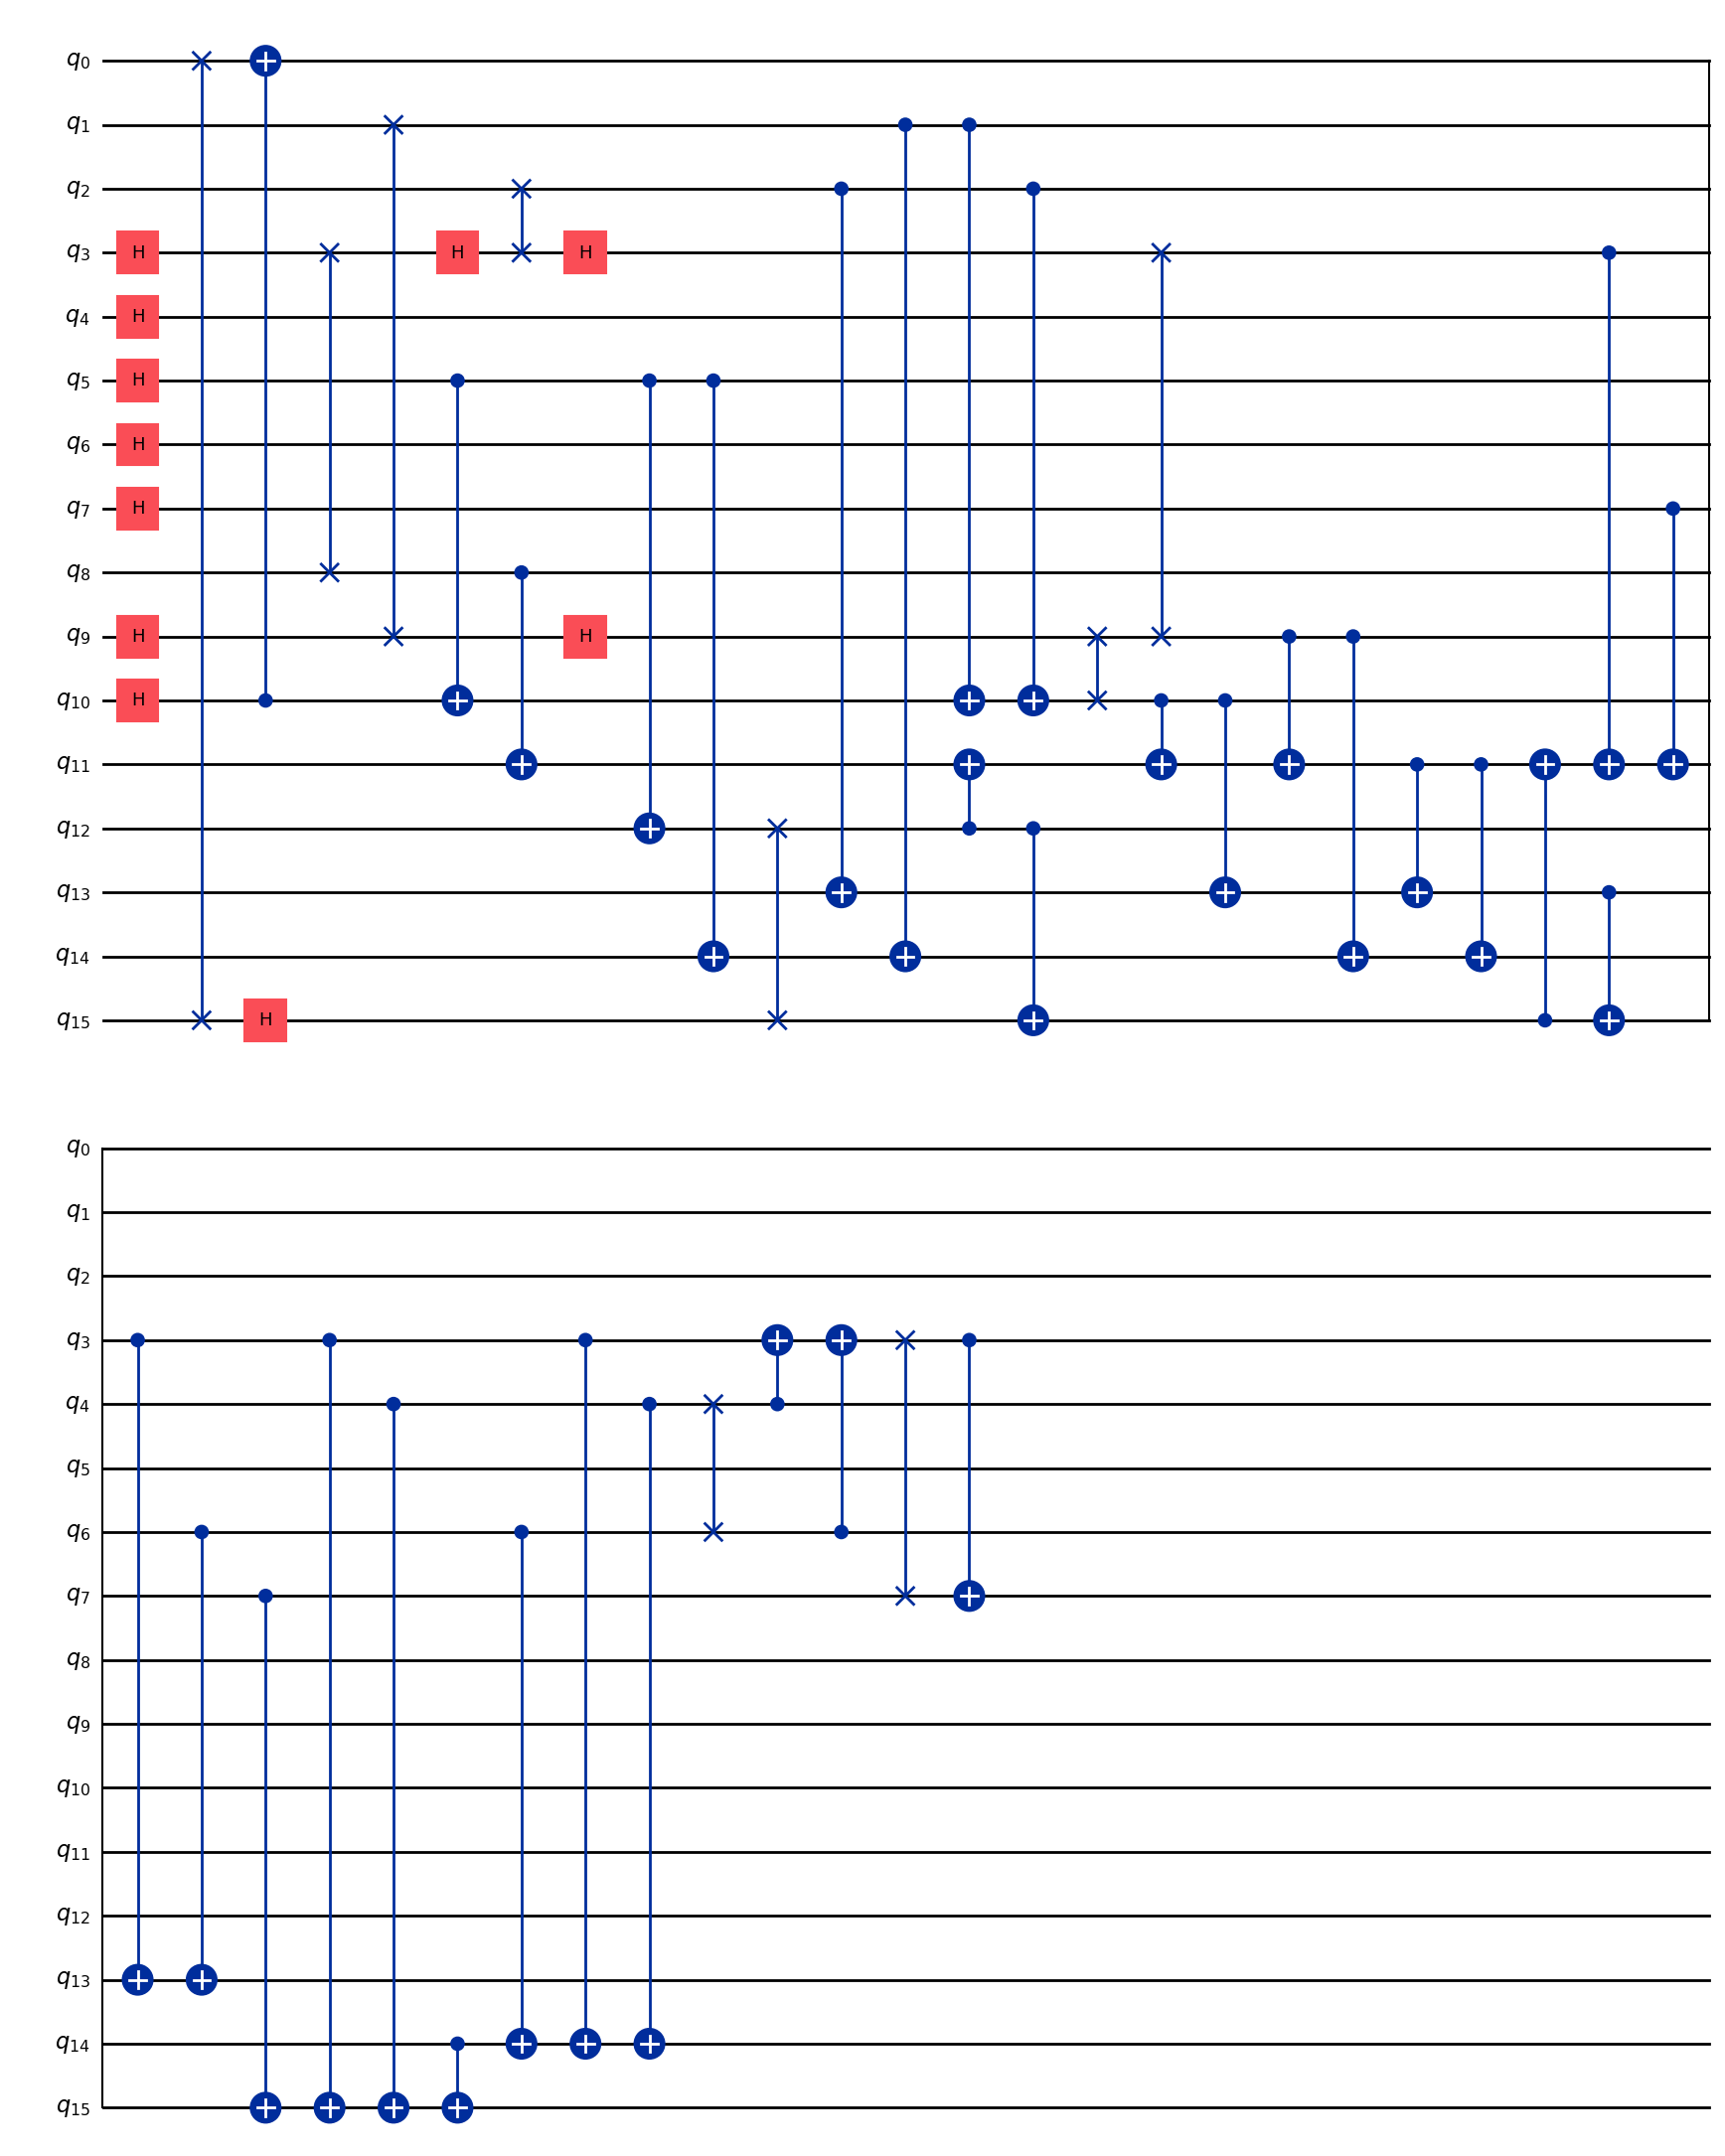

In [ ]:
from qiskit_aer import Aer

stab_list = PauliList(stabilizers)
psi = StabilizerState.from_stabilizer_list(stab_list, allow_underconstrained=True)  

clifford_circ = psi.clifford.to_circuit()
clifford_circ.draw("mpl")

#### Mesuaring Syndrome with Expectaion values
With and withouht X error on qubit 4

In [16]:
for stab in stab_list:
    ev = psi.expectation_value(stab)
    print(f"{stab}: {'+1' if ev > 0 else '-1'}")

XXXXIIIIIIIIIIII: +1
XXIIXXIIIIIIIIII: +1
XIXIXIXIIIIIIIII: +1
IXXIXIIXIIIIIIII: +1
XXIIIIIIXXIIIIII: +1
XIXIIIIIXIXIIIII: +1
IXXIIIIIXIIXIIII: +1
XIIIXIIIXIIIXIII: +1
IXIIXIIIXIIIIXII: +1
IIXIXIIIXIIIIIXI: +1
XXXIXIIIXIIIIIIX: +1
ZZZZZZZZIIIIIIII: +1
ZZZZIIIIZZZZIIII: +1
ZZIIZZIIZZIIZZII: +1
ZIZIZIZIZIZIZIZI: +1


In [20]:
from qiskit.quantum_info import Pauli, Operator

error = Pauli("IIIIXIIIIIIIIIII")
errored_state = psi.evolve(error)

for stab in stab_list:
    ev = errored_state.expectation_value(stab)
    print(f"{stab}: {'+1' if ev > 0 else '-1'}")

XXXXIIIIIIIIIIII: +1
XXIIXXIIIIIIIIII: +1
XIXIXIXIIIIIIIII: +1
IXXIXIIXIIIIIIII: +1
XXIIIIIIXXIIIIII: +1
XIXIIIIIXIXIIIII: +1
IXXIIIIIXIIXIIII: +1
XIIIXIIIXIIIXIII: +1
IXIIXIIIXIIIIXII: +1
IIXIXIIIXIIIIIXI: +1
XXXIXIIIXIIIIIIX: +1
ZZZZZZZZIIIIIIII: -1
ZZZZIIIIZZZZIIII: +1
ZZIIZZIIZZIIZZII: -1
ZIZIZIZIZIZIZIZI: -1


In [ ]:
import numpy as np

HZ = np.array([
 [1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0],
 [1,1,1,1,0,0,0,0,1,1,1,1,0,0,0,0],
 [1,1,0,0,1,1,0,0,1,1,0,0,1,1,0,0],
 [1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0]
]) % 2

sZ = np.array([1,0,1,1])  

for i in range(16):
    e = np.zeros(16, dtype=int)
    e[i] = 1
    syn = (HZ @ e) % 2
    if np.array_equal(syn, sZ):
        print("Likely X error on qubit", i)

Likely X error on qubit 4


#### Measuring Syndrome with Circuit

In [42]:
stabilizers = [
    "XXXXIIIIIIIIIIII",
    "XXIIXXIIIIIIIIII",
    "XIXIXIXIIIIIIIII",
    "IXXIXIIXIIIIIIII",
    "XXIIIIIIXXIIIIII",
    "XIXIIIIIXIXIIIII",
    "IXXIIIIIXIIXIIII",
    "XIIIXIIIXIIIXIII",
    "IXIIXIIIXIIIIXII",
    "IIXIXIIIXIIIIIXI",
    "XXXIXIIIXIIIIIIX",
    "ZZZZZZZZIIIIIIII",
    "ZZZZIIIIZZZZIIII",
    "ZZIIZZIIZZIIZZII",
    "ZIZIZIZIZIZIZIZI"
]

In [43]:
n_data = 16
n_stab = len(stabilizers)

qr_data = QuantumRegister(n_data, 'data')
qr_anc = QuantumRegister(n_stab, 'anc')
cr_syn = ClassicalRegister(n_stab, 'syn')

qc = QuantumCircuit(qr_data, qr_anc, cr_syn)

In [44]:
from qiskit.circuit import QuantumCircuit, Gate

logical_zero_gate = Gate(name="Logical0", num_qubits=16, params=[])
logical_zero_gate.definition = clifford_circ

qc.append(logical_zero_gate, qr_data)

In [47]:
error_qubit = np.random.randint(0, n_data)
qc.x(error_qubit)

In [48]:
for i, stab in enumerate(stabilizers):
    stab_type = 'X' if 'X' in stab and 'Z' not in stab else 'Z'

    if stab_type == 'X':
        for q, p in enumerate(stab):
            if p == 'X':
                qc.h(qr_data[q])

    for q, p in enumerate(stab):
        if p in ['X', 'Z']:
            qc.cx(qr_data[q], qr_anc[i])

    if stab_type == 'X':
        for q, p in enumerate(stab):
            if p == 'X':
                qc.h(qr_data[q])

    qc.measure(qr_anc[i], cr_syn[i])

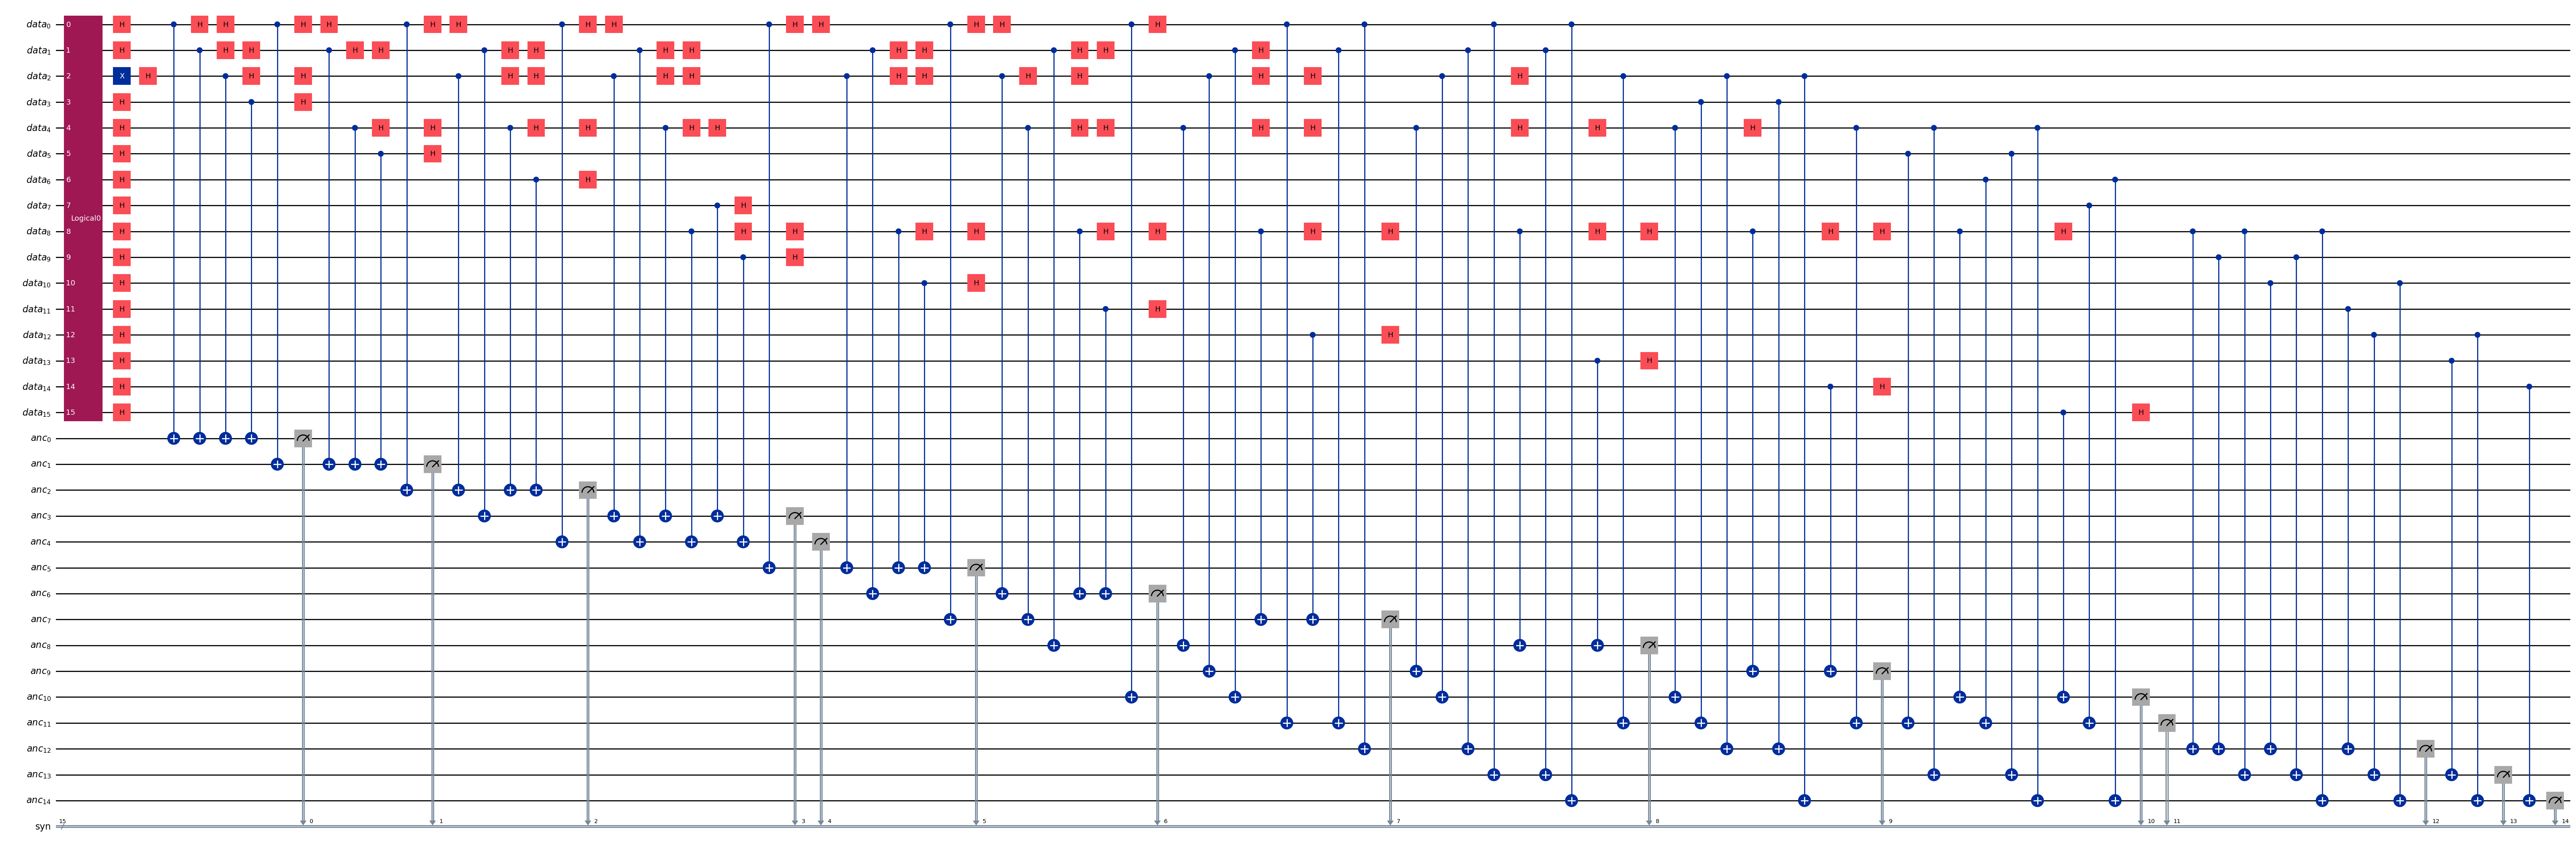

In [49]:
qc.draw("mpl", fold=1)

In [54]:
from qiskit_aer import AerSimulator
from qiskit import transpile

backend = AerSimulator(method='automatic', coupling_map=None)

qc_isa = transpile(qc, backend)
job = backend.run(qc_isa, shots=1)
result = job.result()
counts = result.get_counts()

syndrome = list(counts.keys())[0]
print("Measured syndrome:", syndrome)

CircuitTooWideForTarget: 'Number of qubits (31) in circuit-65 is greater than maximum (30) in the coupling_map'